<a href="https://colab.research.google.com/github/ritikaiitrpr/X-RAY-IMAGE-CLASSIFICATION-FOR-COVID19-DETECTION-USING-CONVOLUTIONAL-NEURAL-NETWORK/blob/main/CNN_BTP11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
import tensorflow as tf
from keras.utils import to_categorical
from keras.layers import Conv2D, Dense, Flatten, MaxPool2D, Dropout
from keras.preprocessing import image
from keras.models import Sequential
import keras
from keras.preprocessing import image
import numpy as np
import pandas as pd
import glob
import os
import cv2
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# creating the image data generator to standardize images
datagen = image.ImageDataGenerator(featurewise_center =True,
      featurewise_std_normalization = True)
datagen = image.ImageDataGenerator(rescale=1/125,horizontal_flip=True,zoom_range=0.2,rotation_range=20,shear_range =0.2)
data = datagen.flow_from_directory(directory= '/content/drive/MyDrive/Dataset', target_size=(256,256),batch_size=16, class_mode='binary')

Found 4561 images belonging to 3 classes.


LOADING DATA

In [ ]:
import matplotlib.pyplot as plt #For Visualization
import numpy as np              #For handling arrays
import pandas as pd             # For handling data
#Define Directories for train, test & Validation Set
train_path = '/content/drive/MyDrive/Dataset/Train'
test_path = '/content/drive/MyDrive/Dataset/Test'
valid_path = '/content/drive/MyDrive/Dataset/Val'
#Define some often used standard parameters
#The batch refers to the number of training examples utilized in one #iteration
batch_size = 16
#The dimension of the images we are going to define is 500x500 img_height = 500

DATA AUGMENTATION

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
# Create Image Data Generator for Train Set
image_gen = ImageDataGenerator(
                                  rescale = 1./255,
                                  shear_range = 0.2,
                                  zoom_range = 0.2,
                                  horizontal_flip = True,
                               )
# Create Image Data Generator for Test/Validation Set
test_data_gen = ImageDataGenerator(rescale = 1./255)

LOADING IMAGES

In [ ]:
img_height = 500
img_width = 500
train = image_gen.flow_from_directory(
      train_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      class_mode='binary',
      batch_size=batch_size
      )
test = test_data_gen.flow_from_directory(
      test_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      shuffle=False,
#setting shuffle as False just so we can later compare it with predicted values without having indexing problem
      class_mode='binary',
      batch_size=batch_size
      )
valid = test_data_gen.flow_from_directory(
     valid_path,
      target_size=(img_height, img_width),
      color_mode='grayscale',
      class_mode='binary',
      batch_size=batch_size
      )

Found 3651 images belonging to 2 classes.
Found 455 images belonging to 2 classes.
Found 455 images belonging to 2 classes.


some of the train set images that we obtained from the Data Augmentation

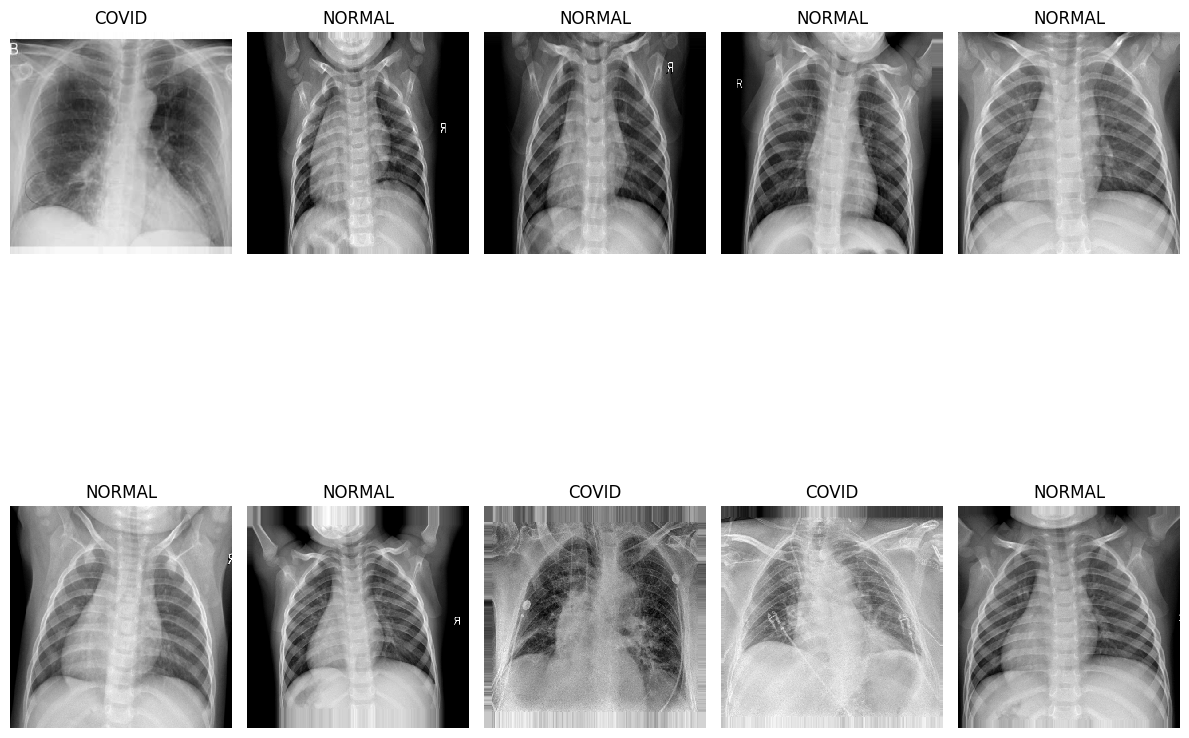

In [ ]:
plt.figure(figsize=(12, 12))
for i in range(0, 10):
    plt.subplot(2, 5, i+1)
    for X_batch, Y_batch in train:
        image = X_batch[0]
        dic = {0:"COVID", 1:"NORMAL"}
        plt.title(dic.get(Y_batch[0]))
        plt.axis("off")
        plt.imshow(np.squeeze(image),cmap="gray",interpolation="nearest")
        break
plt.tight_layout()
plt.show()

OUR CNN ARCHITECTURE

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping,ReduceLROnPlateau

In [ ]:
cnn = Sequential()
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(32, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Conv2D(64, (3, 3), activation="relu", input_shape=(img_width, img_height, 1)))
cnn.add(MaxPooling2D(pool_size = (2, 2)))
cnn.add(Flatten())
cnn.add(Dense(activation = 'relu', units = 128))
cnn.add(Dense(activation = 'relu', units = 64))
cnn.add(Dense(activation = 'sigmoid', units = 1))
cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

VISUALIZING CNN MODEL

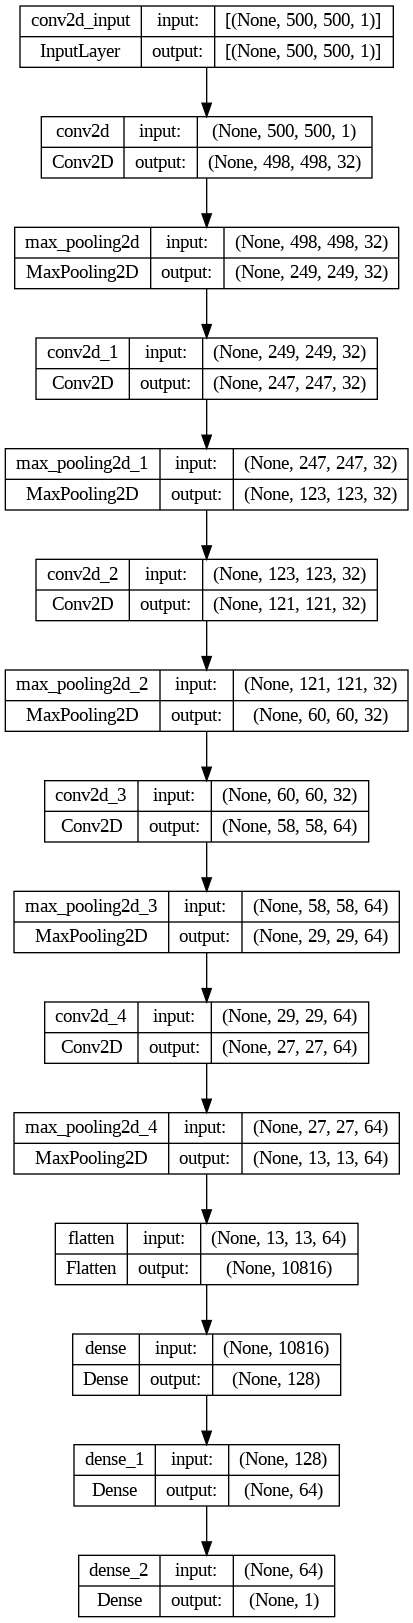

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(cnn,show_shapes=True, show_layer_names=True, rankdir='TB', expand_nested=True)

FITTING THE MODEL

DEFINING CALLBACK LIST

In [ ]:
early = EarlyStopping(monitor="val_loss", mode="min", patience=3)
learning_rate_reduction = ReduceLROnPlateau(monitor="val_loss", patience = 2, verbose=1,factor=0.3, min_lr=0.000001)
callbacks_list = [ early, learning_rate_reduction]

ASSINGING CLASS WEIGHTS


In [ ]:
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(train.classes),
                                        y = train.classes
                                    )
class_weights = dict(zip(np.unique(train.classes), class_weights))
class_weights

{0: 1.7809756097560976, 1: 0.6951637471439451}

TRAINING

In [ ]:
cnn.fit(train,epochs=10, validation_data=valid, class_weight=class_weights, callbacks=callbacks_list)

Epoch 1/10
229/229 [==============================] - 1780s 8s/step - loss: 0.2308 - accuracy: 0.9162 - val_loss: 0.2589 - val_accuracy: 0.9538 - lr: 0.0010
Epoch 2/10
229/229 [==============================] - 1748s 8s/step - loss: 0.1330 - accuracy: 0.9565 - val_loss: 0.0941 - val_accuracy: 0.9758 - lr: 0.0010
Epoch 3/10
229/229 [==============================] - 1820s 8s/step - loss: 0.0929 - accuracy: 0.9680 - val_loss: 0.0985 - val_accuracy: 0.9692 - lr: 0.0010
Epoch 4/10
229/229 [==============================] - ETA: 0s - loss: 0.1035 - accuracy: 0.9666
Epoch 4: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
229/229 [==============================] - 1810s 8s/step - loss: 0.1035 - accuracy: 0.9666 - val_loss: 0.0961 - val_accuracy: 0.9802 - lr: 0.0010
Epoch 5/10
229/229 [==============================] - 1810s 8s/step - loss: 0.0628 - accuracy: 0.9773 - val_loss: 0.0644 - val_accuracy: 0.9824 - lr: 3.0000e-04
Epoch 6/10
229/229 [==============================

EVALUTING

ACCURACY OF TESTDATASET

In [ ]:
test_accu = cnn.evaluate(test)
print('The testing accuracy is :',test_accu[1]*100, '%')

29/29 [==============================] - 154s 5s/step - loss: 0.0522 - accuracy: 0.9868
The testing accuracy is : 98.68131875991821 %


PREDICTING TEST DATASET

In [ ]:
preds = cnn.predict(test,verbose=1)

29/29 [==============================] - 78s 3s/step


In [ ]:
predictions = preds.copy()
predictions[predictions <= 0.5] = 0
predictions[predictions > 0.5] = 1

CONFUSION MATRIX

<Axes: >

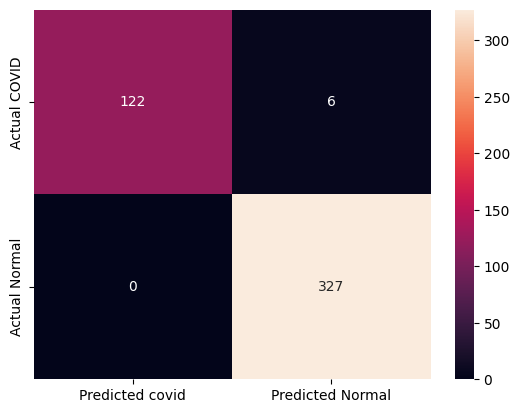

In [ ]:
from sklearn.metrics import classification_report,confusion_matrix
cm = pd.DataFrame(data=confusion_matrix(test.classes, predictions, labels=[0, 1]),index=[ "Actual COVID","Actual Normal"],
columns=[ "Predicted covid","Predicted Normal"])
import seaborn as sns
sns.heatmap(cm,annot=True,fmt="d")

CLASSIFICATION REPORT

In [ ]:
print(classification_report(y_true=test.classes,y_pred=predictions,target_names =['COVID','NORMAL']))

              precision    recall  f1-score   support

       COVID       1.00      0.95      0.98       128
      NORMAL       0.98      1.00      0.99       327

    accuracy                           0.99       455
   macro avg       0.99      0.98      0.98       455
weighted avg       0.99      0.99      0.99       455



VISUALIZING PREDICTED IMAGES

TESTING ON OUR MODEL WITH X-RAY

1/1 [==============================] - 0s 103ms/step


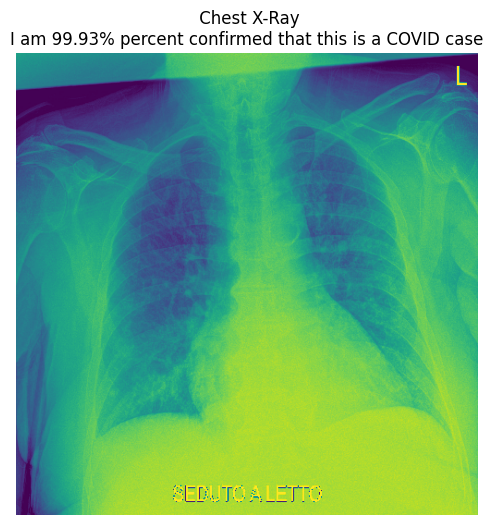

In [ ]:
# Testing with my own Chest X-Ray
our_path = '/content/drive/MyDrive/Dataset/Test/COVID/COVID-19 (1155).jpg'
from tensorflow.keras.preprocessing import image
img = image.load_img(our_path, target_size=(500, 500),color_mode='grayscale')
# Preprocessing the image
pp_img = image.img_to_array(img)
pp_img = pp_img/255
pp_img = np.expand_dims(pp_img, axis=0)
#predict
preds= cnn.predict(pp_img)
#print
plt.figure(figsize=(6,6))
plt.axis('off')
if preds>= 0.5:
   out = ('I am {:.2%} percent confirmed that this is a NORMAL case'.format(preds[0][0]))

else:
    out = ('I am {:.2%} percent confirmed that this is a COVID case'.format(1-preds[0][0]))
plt.title(" Chest X-Ray\n"+out)
plt.imshow(np.squeeze(pp_img))
plt.show()